In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm


In [2]:
imgspath = "/home/isis0517/Documents/data/200324_male_siedview_3"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


40000


(500, 2040)


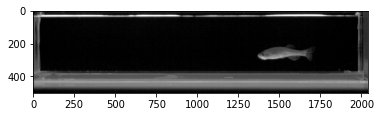

In [3]:
test_frame = np.load(os.path.join(imgspath, flist[5150]))
plt.imshow(test_frame, plt.cm.gray)
print(test_frame.shape)

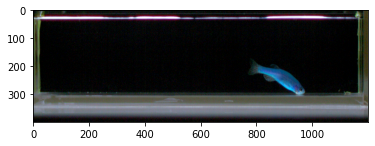

In [4]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
for s in tqdm(range(data_len)):
    
    b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
    b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    a = cv2.resize(a, (1200,400))
    video.write(np.concatenate((b, a), axis=0))
video.release()
plt.imshow(a)


In [5]:

cv2.imwrite("test.png", a)

True

In [7]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
back = np.zeros(a.shape)
for s in tnum:
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    back += a
back = back/len(tnum)
back = back.astype('uint8')

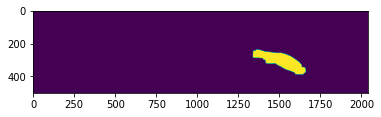

In [8]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
kernel = np.ones((3,3), np.uint8)
for s in tqdm(range(data_len)):
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
    diff = cv2.erode(diff, kernel, iterations = 4)
    diff = cv2.dilate(diff, kernel, iterations = 6)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
video.release()

    
diff = cv2.dilate(diff, kernel, iterations = 3)
plt.imshow(diff)
#cv2.imwrite("test.png", diff)

In [10]:
labels = label(diff, connectivity=2, background=0)
group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [11]:
tnum = np.random.randint(data_len,size = 1000)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


## 轉正圖片 & 儲存

In [12]:
NT_skeleton(background, di_num=3)


array([[ 465, 1296],
       [ 431, 1189],
       [ 431, 1068],
       [ 430,  947],
       [ 431,  828],
       [ 431,  707],
       [ 431,  586],
       [ 432,  465],
       [ 432,  344],
       [ 464,  240]])

In [13]:
imgs = []
h_ans = []

for s in tqdm(range(data_len)):
    
    img = np.load(os.path.join(imgspath, flist[s+data_len]))
    img = cv2.absdiff(img, background)
    img = np.where(img>120, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    imgs.append(rotated)
    h_ans.append(angle)

(201, 201)


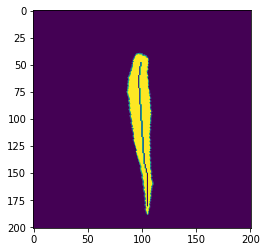

In [14]:
s = 4827
sk = NT_skeleton(imgs[s])

print(imgs[s].shape)
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [15]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs)):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

## apply the eigenfish

In [18]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    han_sks.append(han_sk)
print(len(han_sks))    



20000


## find the pca

[0.89820935 0.05965143 0.01185428] 0.9697150607363019


array([-0.13791866,  0.01490891, -0.06605986])

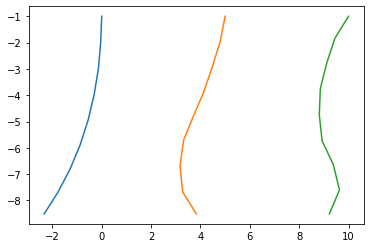

In [19]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

## apply the Kmeans

In [20]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

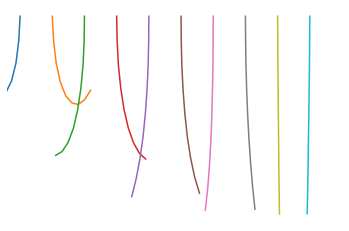

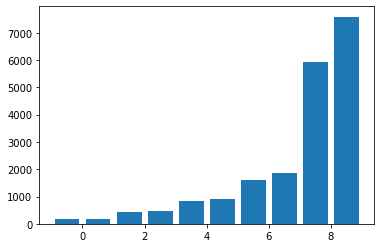

In [21]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

0


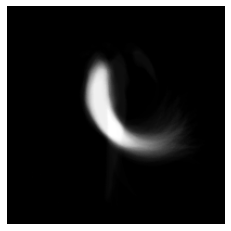

1


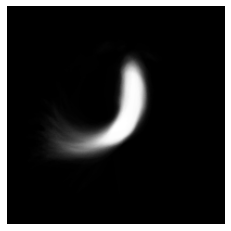

2


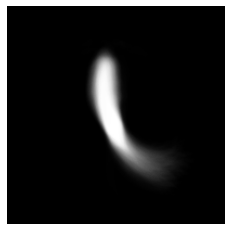

3


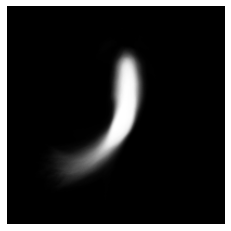

4


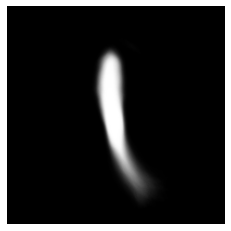

5


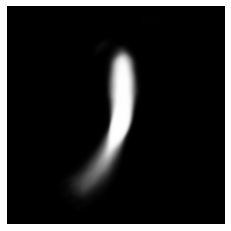

6


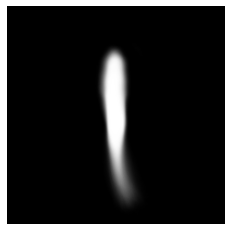

7


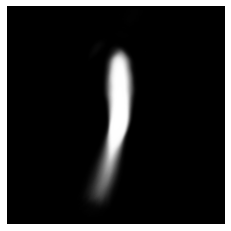

8


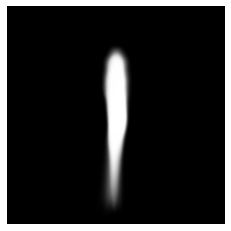

9


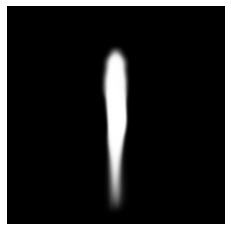

In [22]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()

(array([ 481., 2060., 5972.,  570.,  168.,  231., 1219., 6687., 2014.,
         598.]),
 array([-3.11035282, -2.48515827, -1.85996373, -1.23476918, -0.60957463,
         0.01561992,  0.64081446,  1.26600901,  1.89120356,  2.51639811,
         3.14159265]),
 <BarContainer object of 10 artists>)

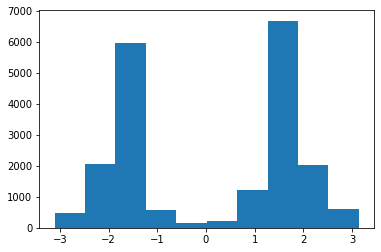

In [23]:
plt.hist(h_ans)

# 產生對應的side view

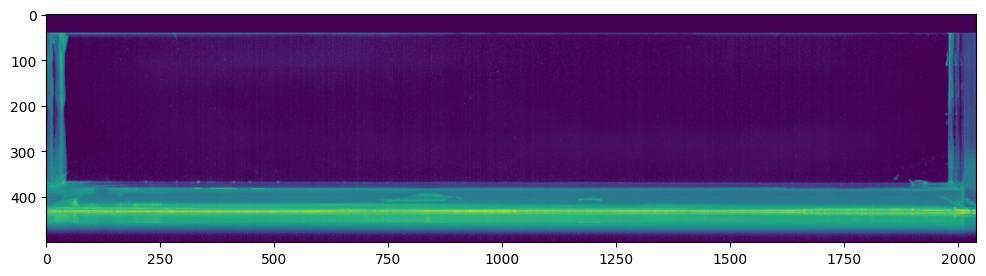

In [24]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = np.load(os.path.join(imgspath, flist[10]))
side_back = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)

aq_mask = np.full(a.shape, True)
aq_mask[0:41, ...] = False
plt.imshow(side_back*aq_mask)
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')


In [26]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (50, 160), (350, 240), (1,1,1), -1)
print(np.sum(stand*150))

sideviews = []
kernel = np.ones((3,3), np.uint8)
for s in tqdm(range(data_len)):
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>30)*255).astype('uint8')
    cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    
    diff = cv2.erode(diff, kernel, iterations = 3)
    diff = cv2.dilate(diff, kernel, iterations = 5)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, get_pos(diff), size = 200)
    if h_ans[s] < 0:
        img = img[:, ::-1, ...]
    #print(np.sum(img*stand))
    sideviews.append(img)
    

#cv2.imwrite("test.png", diff)

10971450


In [27]:
ords = np.lexsort(pca_sks.T[::-1], axis=-1)
sort_pca = pca_sks[ords]
inv_ords = np.zeros(len(pca_sks))
inv_ords[ords] = np.arange(len(pca_sks), dtype=np.int)

pca_sks[0:10].T[::-1]
print(pca_sks[ords])

[[-5.37060652 -0.87035033  0.10078026]
 [-5.13466332 -0.15734612  0.21303511]
 [-5.09362695 -0.21201565  0.11170786]
 ...
 [ 5.27117287  1.15067933  0.37871519]
 [ 5.61830652  2.44933843  1.11754524]
 [ 5.66225347  0.71123269 -0.43137117]]


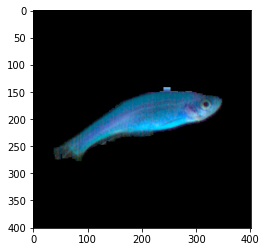

In [28]:
h_ans[200]
plt.imshow(sideviews[20])

In [29]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
            print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
        return lower
                    
            

In [30]:
sorter = SortSearch(pca_sks)

In [31]:
print(sorter.sort_arr[:10])

[[-5.37060652 -0.87035033  0.10078026]
 [-5.13466332 -0.15734612  0.21303511]
 [-5.09362695 -0.21201565  0.11170786]
 [-4.96070831 -0.0888396  -0.08018128]
 [-4.87372664 -0.03722638  0.29827365]
 [-4.8123644  -0.68836463  0.09793751]
 [-4.75698098 -0.53520322 -0.11095506]
 [-4.75539256 -0.14569615  0.0273477 ]
 [-4.73504748 -0.56174749  0.09461033]
 [-4.71790808 -0.37881571  0.31597239]]


In [32]:
print(sorter.search([-1,1,1]))

lower : 0, upper : 20000
lower : 0, upper : 10000
lower : 0, upper : 5000
lower : 0, upper : 2500
lower : 1250, upper : 2500
lower : 1250, upper : 1875
lower : 1250, upper : 1562
lower : 1406, upper : 1562
lower : 1484, upper : 1562
lower : 1523, upper : 1562
lower : 1523, upper : 1542
lower : 1523, upper : 1532
lower : 1523, upper : 1527
lower : 1525, upper : 1527
1525


# load the other vidoe

this data is hard to get the posture 

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


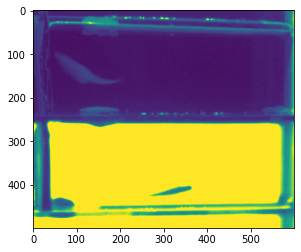

In [33]:
path2 = r"/home/isis0517/Documents/data/MFd/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a)

In [ ]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.3))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

In [ ]:
new_mask = np.full(new_background.shape, False)
new_mask[250:455, :] = True
plt.imshow(new_background*new_mask)

In [ ]:
new_imgs = []
for filename in tqdm(flist2[:100]):
    img = np.load(os.path.join(path2, filename))
    img = (img/255)**0.9*255
    #img = img.astype(np.uint8)
    
    #img = cv2.absdiff(new_background, img)
    #img = np.where(img>100, 255, 0).astype('uint8')
    #pos = get_pos(img)
    #img = cutting_img(img, pos, 100)
plt.imshow(img)

# another vidoe

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


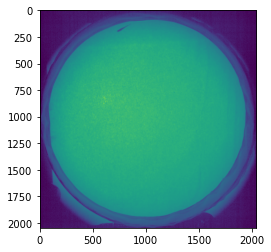

In [77]:
path2 = r"/media/isis0517/QVO2/0115/03"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist[:-2]
img = np.load(os.path.join(path2,flist2[0]))
img = (img/255)**0.6*255
plt.imshow(img)

0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 | 40 | 41 | 42 | 43 | 44 | 45 | 46 | 47 | 48 | 49 | 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 | 60 | 61 | 62 | 63 | 64 | 65 | 66 | 67 | 68 | 69 | 70 | 71 | 72 | 73 | 74 | 75 | 76 | 77 | 78 | 79 | 80 | 81 | 82 | 83 | 84 | 85 | 86 | 87 | 88 | 89 | 90 | 91 | 92 | 93 | 94 | 95 | 96 | 97 | 98 | 99 | 100 | 101 | 102 | 103 | 104 | 105 | 106 | 107 | 108 | 109 | 110 | 111 | 112 | 113 | 114 | 115 | 116 | 117 | 118 | 119 | 120 | 121 | 122 | 123 | 124 | 125 | 126 | 127 | 128 | 129 | 130 | 131 | 132 | 133 | 134 | 135 | 136 | 137 | 138 | 139 | 140 | 141 | 142 | 143 | 144 | 145 | 146 | 147 | 148 | 149 | 150 | 151 | 152 | 153 | 154 | 155 | 156 | 157 | 158 | 159 | 160 | 161 | 162 | 163 | 164 | 165 | 166 | 167 | 168 | 169 | 170 | 171 | 172 | 173 | 174 | 175 | 176 | 177 | 178 | 179 | 180 | 181 | 182 | 183 | 184 | 

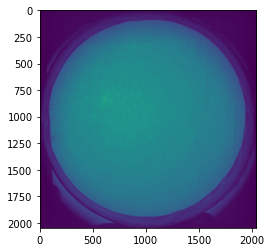

In [83]:
new_background = np.zeros(img.shape, dtype=np.float)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.2))
for s, filename in enumerate(tqdm(flist2[0:1000])):
    print(s, end=" | ")
    a = np.load(os.path.join(path2, flist2[s]))
    #a = (img/255)**0.6*255
    new_background += a
    
new_background = new_background /1000
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

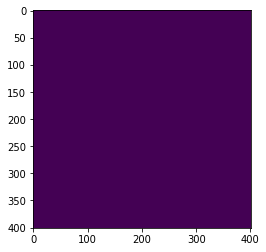

In [71]:
new_imgs = []
for filename in tqdm(flist2[:1]):
    img = np.load(os.path.join(path2, filename))
    img = (img/255)**0.6*255
    img = img.astype(np.uint8)
    img = cv2.absdiff(new_background, img)
    img = np.where(img>40, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 200)
plt.imshow(img)